# Introduction

Music is a form of art that is ubiquitous and has a rich history. Different composers have created music with their unique styles and compositions. However, identifying the composer of a particular piece of music can be a challenging task, especially for novice musicians or listeners. The proposed project aims to use deep learning techniques to identify the composer of a given piece of music accurately.

# Objective

The primary objective of this project is to develop a deep learning model that can predict the composer of a given musical score accurately. The project aims to accomplish this objective by using two deep learning techniques: Long Short-Term Memory (LSTM) and Convolutional Neural Network (CNN).

## Code

In [68]:
"""Imports"""
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from miditok import REMI, TokenizerConfig
from miditok.data_augmentation import augment_dataset
from miditok.pytorch_data import DatasetMIDI, DataCollator
from miditok.utils import split_files_for_training
from torch.utils.data import DataLoader
from pathlib import Path
from random import sample, shuffle, seed as random_seed

In [4]:
"""Set seeds and device"""
random_seed(73)
np.random.seed(73)
torch.manual_seed(73)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(73)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu




### Data Collection: Data is collected and provided to you.

In [3]:
"""Include data EDA from Anitra's branch here"""

"Include data EDA from Anitra's branch here"

### Data Pre-processing: Convert the musical scores into a format suitable for deep learning models. This involves converting the musical scores into MIDI files and applying data augmentation techniques.

In [7]:
"""Train a tokenizer on each composer, split the data by number of tokens and augment the data"""
config = TokenizerConfig(use_chords=True, use_rests=True, use_tempos=True, use_programs=True)
tokenizer = REMI(config)

DATA_PATH = Path(Path.cwd().parent, "Data")
RETAIN = 10000

for composer in ["Bach", "Beethoven", "Chopin", "Mozart"]:
	print(f"{composer}:")
	midi_path = list(Path(DATA_PATH).glob(f"{composer}/*.mid"))
	tokenizer.train(vocab_size=30000, files_paths=midi_path)
	subset_chunks_dir = Path(DATA_PATH, f"{composer}_augmented")
	
	split_files_for_training(
        files_paths=midi_path,
        tokenizer=tokenizer,
        save_dir=subset_chunks_dir,
        max_seq_len=1024,
        num_overlap_bars=2,
    )

	augment_dataset(
		subset_chunks_dir,
		pitch_offsets=[-6, 6],
		velocity_offsets=[-4, 4],
		duration_offsets=[-0.2, 0.2],
		save_data_aug_report=False,
		all_offset_combinations=composer == "Chopin" # perform more augmentation if chopin (low token count)
	)

	# use RETAIN as upper bound of song count and remove excess at random to balance composer data
	all_files = list(Path(subset_chunks_dir).glob("*.mid"))
	composer_sample = sample(all_files, len(all_files) - RETAIN)
	for file_name in composer_sample:
		file_name.unlink()

Bach:
Performing data augmentation: 100%|██████████| 2263/2263 [00:24<00:00, 500.35it/s]
Beethoven:
Performing data augmentation: 100%|██████████| 3004/3004 [00:27<00:00, 460.36it/s]
Chopin:
Performing data augmentation: 100%|██████████| 11754/11754 [01:38<00:00, 119.72it/s]
Mozart:
Performing data augmentation: 100%|██████████| 2588/2588 [00:04<00:00, 527.91it/s]


### Feature Extraction: Extract features from the MIDI files, such as notes, chords, and tempo, using music analysis tools.

In [ ]:
"""Combine all MIDIs and train new tokenizer using combined data"""
combined_midi_path = list(Path(DATA_PATH).glob(f"*_augmented/*.mid"))

tokenizer = REMI(config)
tokenizer.train(vocab_size=30000, files_paths=combined_midi_path)

In [ ]:
"""Split into train/valid/test datasets using roughly 15% of the data for each of valid and test"""
total_num_files = len(combined_midi_path)
num_files_valid = round(total_num_files * 0.15)
num_files_test = round(total_num_files * 0.15)
shuffle(combined_midi_path)
midi_paths_valid = combined_midi_path[:num_files_valid]
midi_paths_test = combined_midi_path[num_files_valid:num_files_valid + num_files_test]
midi_paths_train = combined_midi_path[num_files_valid + num_files_test:]

for files_paths, subset_name in (
    (midi_paths_train, "Train"), (midi_paths_valid, "Validate"), (midi_paths_test, "Test")
):
    subset_chunks_dir = Path(DATA_PATH, subset_name)
    split_files_for_training(
        files_paths=files_paths,
        tokenizer=tokenizer,
        save_dir=subset_chunks_dir,
        max_seq_len=1024,
        num_overlap_bars=2,
    )

Splitting music files: 100%|██████████| 6000/6000 [00:09<00:00, 614.17it/s]


In [ ]:
"""Train new tokenizer based on training data only and save the weights locally"""
training_midi_path = list(Path(DATA_PATH).glob(f"Train/**/*.mid"))

tokenizer = REMI(config)
tokenizer.train(vocab_size=30000, files_paths=training_midi_path)

tokenizer.save_pretrained("tokenizer.json")

In [6]:
"""Load the tokenizer using the locally saved weights"""
DATA_PATH = Path(Path.cwd().parent, "Data")
tokenizer = REMI(TokenizerConfig(use_chords=True, use_rests=True, use_tempos=True, use_programs=True)).from_pretrained("tokenizer.json")
tokenizer.is_trained

True

In [46]:
"""Create torch compatable data loaders using the datasets created above"""
class Capture:
	def __init__(self):
		self.score = None
		self.tok_sequence = None
	
	def lable_composer(self, score, tok_sequence, file_path):
		self.score = score
		self.tok_sequence = tok_sequence
		composer = file_path.parts[-2:-1]
		if "Bach" in composer:
			return [1,0,0,0]
		elif "Beethoven" in composer:
			return [0,1,0,0]
		elif "Chopin" in composer:
			return [0,0,1,0]
		elif "Mozart" in composer:
			return [0,0,0,1]
		else:
			return [0,0,0,0]
		
capture = Capture()
collator = DataCollator(tokenizer.pad_token_id)

dataset_train = DatasetMIDI(
    files_paths=list(Path(DATA_PATH, "Train").glob("**/*.mid")),
    tokenizer=tokenizer,
    max_seq_len=1024,
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"],
    func_to_get_labels=capture.lable_composer
)
dataloader_train = DataLoader(dataset_train, batch_size=64, collate_fn=collator, shuffle=True)

dataset_valid = DatasetMIDI(
    files_paths=list(Path(DATA_PATH, "Validate").glob("**/*.mid")),
    tokenizer=tokenizer,
    max_seq_len=1024,
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"],
	func_to_get_labels=capture.lable_composer
)
dataloader_valid = DataLoader(dataset_valid, batch_size=64, collate_fn=collator, shuffle=True)

dataset_test = DatasetMIDI(
    files_paths=list(Path(DATA_PATH, "Test").glob("**/*.mid")),
    tokenizer=tokenizer,
    max_seq_len=1024,
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"],
	func_to_get_labels=capture.lable_composer
)
dataloader_test = DataLoader(dataset_test, batch_size=64, collate_fn=collator)

In [47]:
for data in dataloader_train:
	inputs = data["input_ids"].reshape([64, 1, 1024]).type(torch.float32)
	labels = data["labels"]
	print(inputs.dtype)
	print(len(labels))
	break

torch.float32
64


### Model Building: Develop a deep learning model using LSTM and CNN architectures to classify the musical scores according to the composer.

In [70]:
"""LSTM and CNN definitions"""
class ComposerLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0):
        super(ComposerLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        h_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h_0, c_0))  # out: [batch, seq_len, hidden]
        out = out[:, -1, :]  # Take last timestep
        out = nn.functional.relu(self.fc1(out))
        return self.fc2(out)
    
class ComposerCNN(nn.Module):
    def __init__(self):
        super(ComposerCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(768, 256)
        self.fc2 = nn.Linear(256, 32)
        
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        return nn.functional.softmax(x, dim=1)

### Model Training: Train the deep learning model using the pre-processed and feature-extracted data.

In [ ]:
"""Define training loop for LSTM"""
def train(model, training, validation, lr=0.001):
	criterion = nn.MSELoss()
	optimizer = torch.optim.Adam(model.parameters(), lr=lr)
	
	train_losses = []
	for data in training:
		inputs = data["input_ids"].reshape([64, 1, 1024]).type(torch.float32)
		labels = data["labels"].float()
		model.train()
		optimizer.zero_grad()
		output = model(inputs)
		loss = criterion(output, labels)
		loss.backward()
		optimizer.step()
		train_losses.append(loss.item())

	validation_losses = []
	with torch.no_grad():
		for v_data in validation:
			v_inputs = v_data["input_ids"].reshape([64, 1, 1024]).type(torch.float32)
			v_labels = v_data["labels"].float()
			model.eval()
			test_output = model(v_inputs)
			validation_loss = criterion(test_output, v_labels)	
			validation_losses.append(validation_loss.item())
	return train_losses, validation_losses

# Train LSTM model
epochs = 10
model = ComposerLSTM(input_size=1024, hidden_size=4096, num_layers=1, num_classes=4)

total_train_losses = []
total_validation_losses = []

for epoch in range(epochs):
	epoch_train_loss, epoch_validation_loss = train(model, dataloader_train, dataloader_valid)
	total_train_losses.extend(epoch_train_loss)
	total_validation_losses.extend(epoch_validation_loss)
	if (epoch + 1) % 10 == 0:
		print(f"Epoch {epoch + 1}, train loss: {epoch_train_loss[-1]:.4f}, validation loss: {epoch_validation_loss[-1]:.4f}")

Epoch 10, train loss: 0.2076, validation loss: 0.2052


# Note:
My maths indicate that each epoch will take roughly 23 minutes on my machine (i5 Intel).

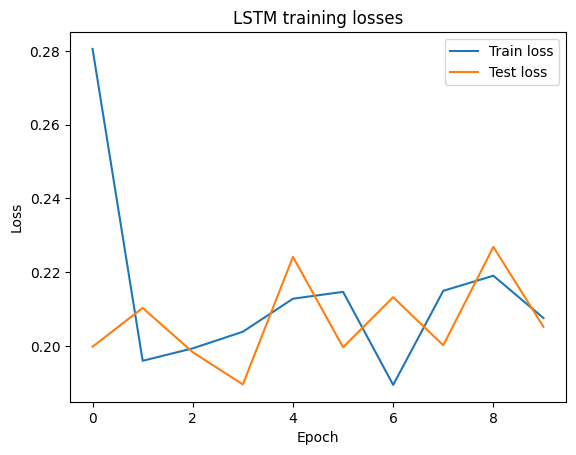

In [75]:
"""Plot training and test losses"""
plt.title("LSTM training losses")
plt.ylabel("Loss")
plt.xlabel("Epoch")

plt.plot(total_train_losses, label="Train loss")
plt.plot(total_validation_losses, label="Test loss")
plt.legend()
plt.show()

### Model Evaluation: Evaluate the performance of the deep learning model using accuracy, precision, and recall metrics.

### Model Optimization: Optimize the deep learning model by fine-tuning hyperparameters.

## Findings